# Lecture 7 - Bayesian Hierarchical Models

## Today's Learning Objectives

1. Explain the concept of the Bayesian hierarchical model.
2. Contrast the hierarchical model versus standard Bayesian models.
3. Demonstrate the advantages of hierarchical modelling in Bayesian inference.
4. Apply hierarchical modelling to predictive inquiries.

## Loading `R` Packages

In [1]:
options(repr.matrix.max.rows = 6)
library(tidyverse)
library(rstan)
library(broom.mixed)
library(bayesplot)
library(cowplot)
library(bayesrules)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: StanHeaders




rstan version 2.32.6 (Stan version 2.32.2)




For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)





Attaching package: ‘rstan’




The following object is masked from ‘package:tidyr’:

    extract




This is bayesplot version 1.11.1



- Online documentation and vignettes at mc-stan.org/bayesplot



- bayesplot theme set to bayesplot::theme_default()



   * Does _not_ affect other ggplot2 plots



   * See ?bayesplot_theme_set for details on theme setting




Attaching package: ‘cowplot’




The following object is masked from ‘package:lubridate’:

    stamp




## Previously...

We are in the last week of the block, and we have been exposed to **standard Bayesian models**. These models involve **a likelihood conditioned on parameters of interest, which are random variables**. These parameters have **prior distributions**. Furthermore, **these priors have fixed hyperparameters**. 

Suppose you want to make inference on the **mean number of people** who stand in line, from 9:00 to 10:00 a.m. on Mondays, in the branches of a major Canadian bank. You collect data across different branches during that time slot and end up with $n$ observations. Moreover, you decide to take a Bayesian approach for this inquiry.

Nonetheless, we can make **a flexible model in such a way we assign a mean by branch**. Hence, let $S_i$ be the number of **people** standing in line from 9:00 to 10:00 a.m. on Mondays in the $i$th branch $(i = 1, \dots, n)$, and $\theta_i$ the mean by branch. Therefore, the formal Bayesian model will be the following:


```{math}
\begin{align*}
\text{likelihood:} \qquad S_i \mid  \theta_i \mathop\sim^\text{ind} \text{Poisson}(\theta_i) \quad \text{for } i = 1, \dots, n \\
\text{priors:} \qquad \theta_i \sim \text{Gamma}(\alpha, \beta) \\
\qquad \alpha \sim \text{Exponential}(\eta = 0.1) \\
\qquad \beta \sim \text{Exponential}(\gamma = 0.5).
\end{align*}
```

Note $\alpha$ and $\beta$ are now random variables! This is  a **hierarchical model**!

```{exercise}
:label: lecture7-q1

Why do $\alpha$ and $\beta$ have Exponential priors?

**A.** Both $\alpha$ and $\beta$ are discrete and nonnegative in the Gamma prior distribution of $\theta_i$.

**B.** Both $\alpha$ and $\beta$ are continuous and unbounded in the Gamma prior distribution of $\theta_i$.

**C.** Both $\alpha$ and $\beta$ are continuous and nonnegative in the Gamma prior distribution of $\theta_i$.

**D.** Both $\alpha$ and $\beta$ are discrete and unbounded in the Gamma prior distribution of $\theta_i$.
```

## 1. The Rockets Data

To illustrate the differences between the Bayesian models we have seen so far and the concept of **hierarchy**, we will retake the `rockets` problem from `lab2`. Then, throughout the lecture, we will build different Bayesian arrangements until we get to a hierarchical model. This will highlight these differences according to each model's specific inferential inquiry.

```{important}
Recall `rockets` contains data on 367 rockets. It has three columns: 

- `LV.Type`: The rocket's type.
- `numberOfLaunches`: Number of launches.
- `numberOfFailures`: Number of failures.
```

In [2]:
rockets <- read_csv("../data/failure_counts.csv", show_col_types = FALSE)
rockets

LV.Type,numberOfLaunches,numberOfFailures
<chr>,<dbl>,<dbl>
Aerobee,1,0
Angara A5,1,0
Antares 110,2,0
⋮,⋮,⋮
Zenit-3SL,36,3
Zenit-3SLB,6,0
Zenit-3SLBF,3,0


## 2. Single Rocket Model (Warmup!)

Let 

$$X|\pi \sim \text{Binomial}(n,\pi)$$

be the number of successes that a **specific** rocket had in $n$ launches. We will assume that the **probability of success** $\pi$ is a continuous random variable that can take any value in the interval $[0, 1]$.

As our **prior distribution**, we will define a Beta PDF over the interval $[0, 1]$. Thus, the formal Bayesian model will be:

```{math}
\begin{align*}
\text{likelihood:} \qquad X|\pi \sim \text{Binomial}(n, \pi)\\
\text{prior:} \qquad \pi \sim \text{Beta}(a = 1,b = 1).
\end{align*}
```

Let us call it `Single_Rocket`.


```{attention}
For a **GIVEN type of rocket** (i.e., a row in `rockets`), our goal with `Single_Rocket` will be to infer its **launch success probability $\pi$**.
```

### 2.1. Coding the Model

We start by coding `Single_Rocket` on `Stan`.

In [3]:
Single_Rocket <- "data {                          
int<lower=1> n;    // Number of trials in a given rocket type
int<lower=0> X;    // Number of successes in a given rocket type
real<lower=0> a;   // Hyperparameter for Beta prior
real<lower=0> b;   // Hyperparameter for Beta prior
}
parameters {
real <lower=0,upper=1> pi;    // Probability of launch success in a given rocket type 
}
model {
pi ~ beta(a, b);
X ~ binomial(n, pi);
}"

### 2.2. Running the MCMC Simulation

Suppose you are interested in making inference in the launch success probability $\pi$ for the type `Ariane 1`. Hence, let us use that row from `rockets` as our **observed data**. First, we create the data dictionary and proceed with `stan()`. We use a prior $\text{Beta}(a = 1, b = 1)$ which assumes all values of $\pi$ as equally probable.

In [4]:
options(repr.plot.height = 8, repr.plot.width = 12)

# Plotting Beta(1,1) prior
prior_beta_1_1 <- ggplot() +
  xlim(0, 1) +
  geom_function(fun = dbeta, args = list(shape1 = 1, shape2 = 1), linewidth = 2) +
  theme(
    plot.title = element_text(size = 24),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21),
  ) +
  labs(y = "Density", x = expression(pi)) +
  ggtitle(expression(paste("Prior Beta(1, 1) for ", pi)))

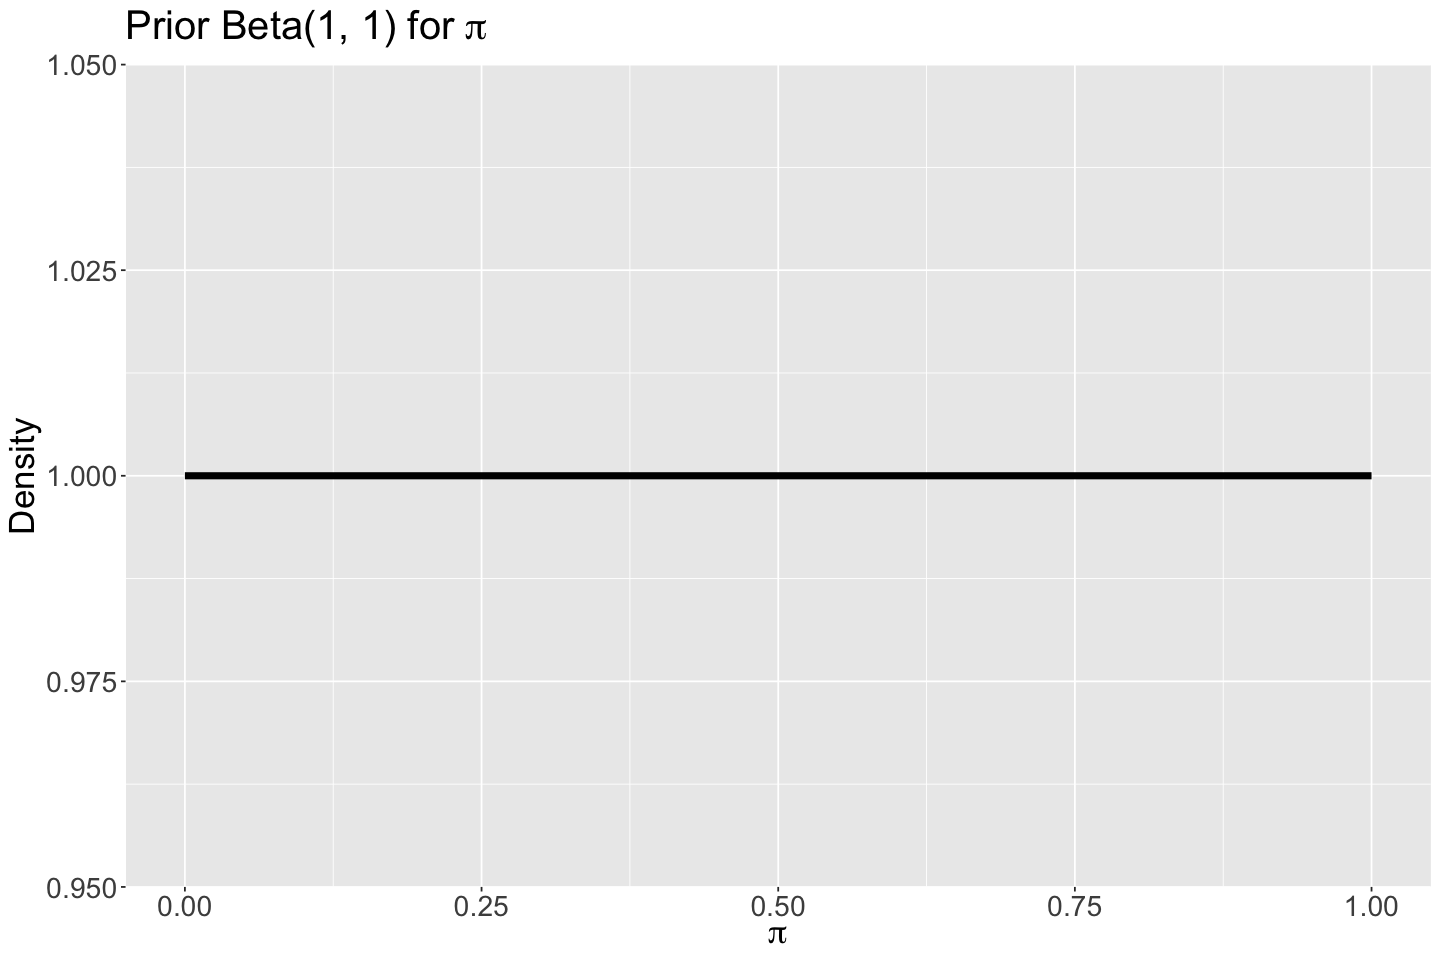

In [5]:
prior_beta_1_1

In [6]:
Ariane_1_data <- rockets |>
  filter(LV.Type == "Ariane 1")
Ariane_1_data

Single_Rocket_dictionary <- list(
  n = Ariane_1_data$numberOfLaunches, 
  X = Ariane_1_data$numberOfLaunches - Ariane_1_data$numberOfFailures, # Successes in Ariane 1
  a = 1, b = 1
)

LV.Type,numberOfLaunches,numberOfFailures
<chr>,<dbl>,<dbl>
Ariane 1,11,2


In [7]:
posterior_Single_Rocket <- stan(
  model_code = Single_Rocket,
  data = Single_Rocket_dictionary,
  chains = 1,
  iter = 10000,
  warmup = 1000,
  thin = 5,
  seed = 553,
)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 4e-06 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 1001 / 10000 [ 10%]  (Sampling)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Sampling)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Sampling)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Sampling)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.002 seconds (Warm-up)
Chain 1:                0.017 seconds (Sampling)
Chain 1: 

### 2.3. Output Summary 

With a left-skewed distribution, our posterior mean of $\pi$ for `Ariane 1` is 0.767. Moreover, **the 95% credible interval shows high variability**. Therefore, we could either increase our sample size for `Ariane 1` (**to have a narrower likelihood**) or tune the Beta prior (**i.e., a prior with less variability**).

In [8]:
summary_Ariane_1 <- as.data.frame(summary(posterior_Single_Rocket)$summary)
summary_Ariane_1 <- summary_Ariane_1[1, c("mean", "sd", "2.5%", "97.5%")] %>%
  mutate_if(is.numeric, round, 3)
summary_Ariane_1

,mean,sd,2.5%,97.5%
,<dbl>,<dbl>,<dbl>,<dbl>
pi,0.767,0.116,0.505,0.945


In [9]:
post_plot_Ariane_1 <- mcmc_areas(posterior_Single_Rocket, pars = "pi", prob = 0.95) +
  theme(
    plot.title = element_text(size = 24, family = "sans"),
    axis.text.x = element_text(size = 17, angle = 0, family = "sans"),
    axis.text.y = element_text(size = 17, angle = 0, family = "sans"),
    axis.title = element_text(size = 21, family = "sans")
  ) +
  labs(title = expression(paste("Approximate Posterior Dist. and 95% Credible Interval of ", pi, " for Ariane 1"))) +
  xlab(expression(pi))

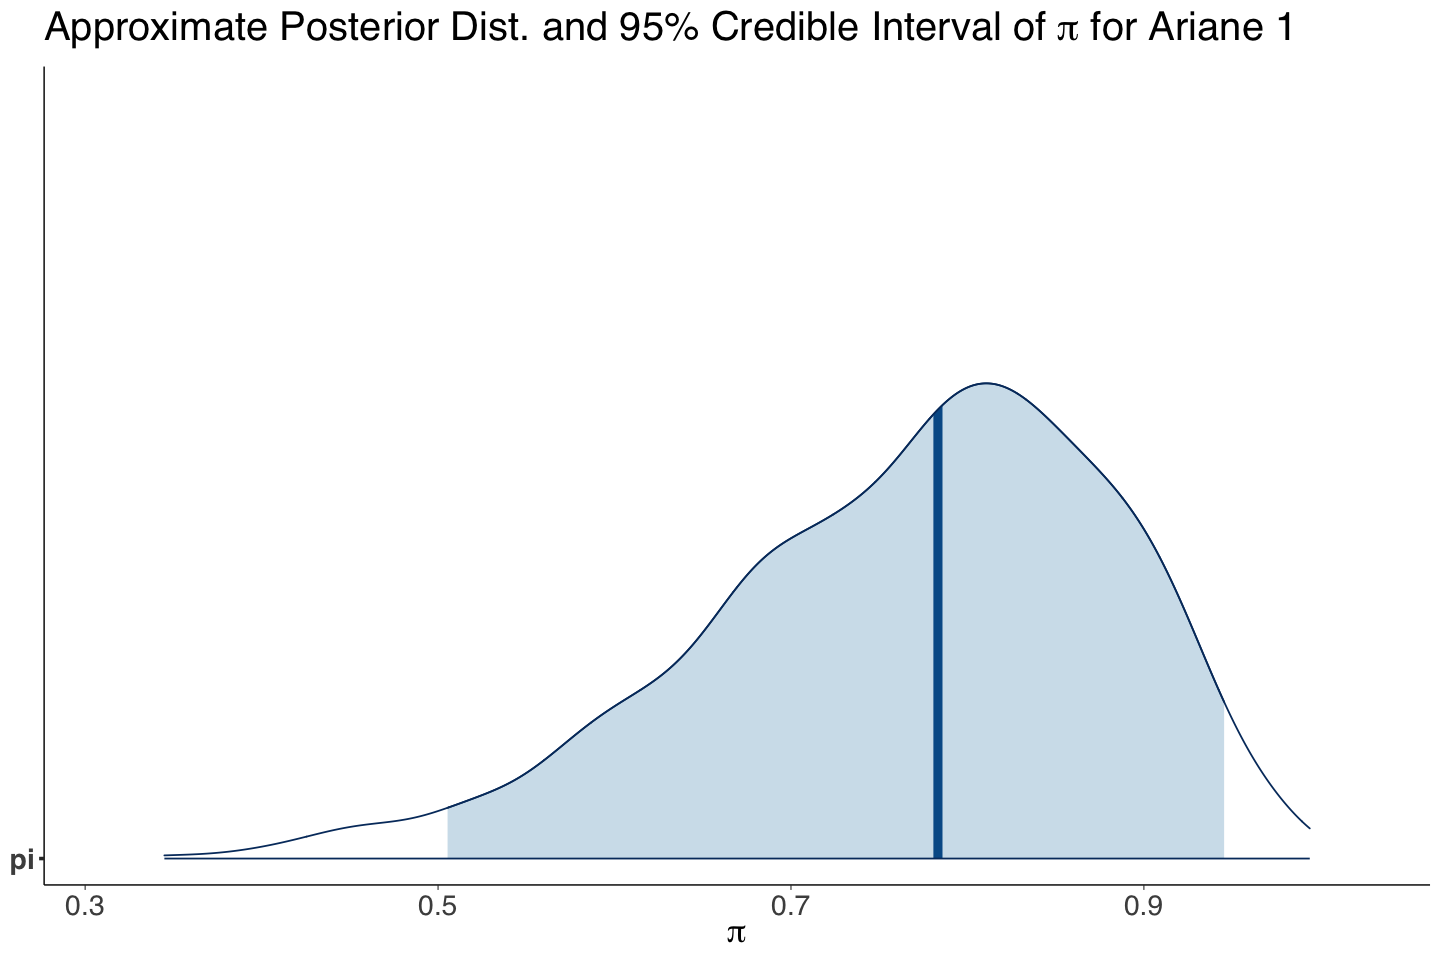

In [10]:
post_plot_Ariane_1

## 3. Complete Pooled Rocket Model

Our second Bayesian approach is called a **complete pooled model**. In this model, we will combine the data provided by **ALL** rockets into **one pool of information**. For the $i$th rocket, the model is:

```{math}
\begin{align*}
\text{likelihood:} \qquad X_i|\pi \sim \text{Binomial}(n_i, \pi) \quad \text{for } i = 1, \dots, 367\\
\text{prior:} \qquad \pi \sim \text{Beta}(a = 1, b = 1).
\end{align*}
```

```{caution}
Even though it might not look like it, this model is quite different from the `SingleRocket` model. The difference is that, in this complete pooled model, **we are considering all the rocket types**. 

While we allow them to have different numbers of launches, we assume that all of them have the same probability of success $\pi$. **In this way, we will be estimating the OVERALL probability of success across all rockets.**
```

### 3.1. Coding the Model

We code up this `Complete_Pooled_Rocket` model on `Stan`. Note the `data` block includes one integer to define the number of rockets to use in the simulation (`num_rockets`), a vector of integers containing all launch successes by rocket (`X[num_rockets]`), and a vector of integers containing all trials by rocket (`n[num_rockets]`).

In [11]:
Complete_Pooled_Rocket <- "data {                          
int<lower=1> num_rockets;     // number of rockets 
int<lower=0> X[num_rockets];  // vector with sucesses by rocket
int<lower=1> n[num_rockets];  // vector with trials by rocket
real<lower=0> a;
real<lower=0> b;  
}
parameters {
real <lower=0,upper=1> pi;
}
model {
pi ~ beta(a, b);
for (i in 1:num_rockets){    // modelling the likelihood by rocket
X[i] ~ binomial(n[i], pi);
}
}"

### 3.2. Running the MCMC Simulation

To build the `Complete_Pooled_Rocket_dictionary` we need to use the corresponding columns from `rockets`. Recall `X` is provided by substracting two columns.

In [12]:
Complete_Pooled_Rocket_dictionary <- list(
  num_rockets = nrow(rockets),
  X = rockets$numberOfLaunches - rockets$numberOfFailures,
  n = rockets$numberOfLaunches,
  a = 1, b = 1
)

In [13]:
posterior_Complete_Pooled_Rocket <- stan(
  model_code = Complete_Pooled_Rocket,
  data = Complete_Pooled_Rocket_dictionary,
  chains = 1,
  iter = 10000,
  warmup = 1000,
  thin = 5,
  seed = 553,
)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.2e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 1001 / 10000 [ 10%]  (Sampling)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Sampling)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Sampling)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Sampling)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.06 seconds (Warm-up)
Chain 1:                0.451 seconds (Sampling)
Chain 1:

### 3.3. Output Summary 

Unlike `Ariane 1`, the posterior distribution of the overall $\pi$ is symmetric with a mean of 0.924. Moreover, **the 95% CI shows a low variability in this posterior distribution**.

In [14]:
summary_Complete_Pooled_Rocket <- as.data.frame(summary(posterior_Complete_Pooled_Rocket)$summary)
summary_Complete_Pooled_Rocket <- summary_Complete_Pooled_Rocket[1, c("mean", "sd", "2.5%", "97.5%")] %>%
  mutate_if(is.numeric, round, 3)
summary_Complete_Pooled_Rocket

,mean,sd,2.5%,97.5%
,<dbl>,<dbl>,<dbl>,<dbl>
pi,0.924,0.004,0.917,0.931


In [15]:
post_plot_Complete_Pooled_Rocket <- mcmc_areas(posterior_Complete_Pooled_Rocket, pars = "pi", prob = 0.95) +
  theme(
    plot.title = element_text(size = 24, family = "sans"),
    axis.text.x = element_text(size = 17, angle = 0, family = "sans"),
    axis.text.y = element_text(size = 17, angle = 0, family = "sans"),
    axis.title = element_text(size = 21, family = "sans")
  ) +
  labs(title = expression(paste("Approximate Posterior Dist. and 95% Credible Interval of ", pi))) +
  xlab(expression(pi))

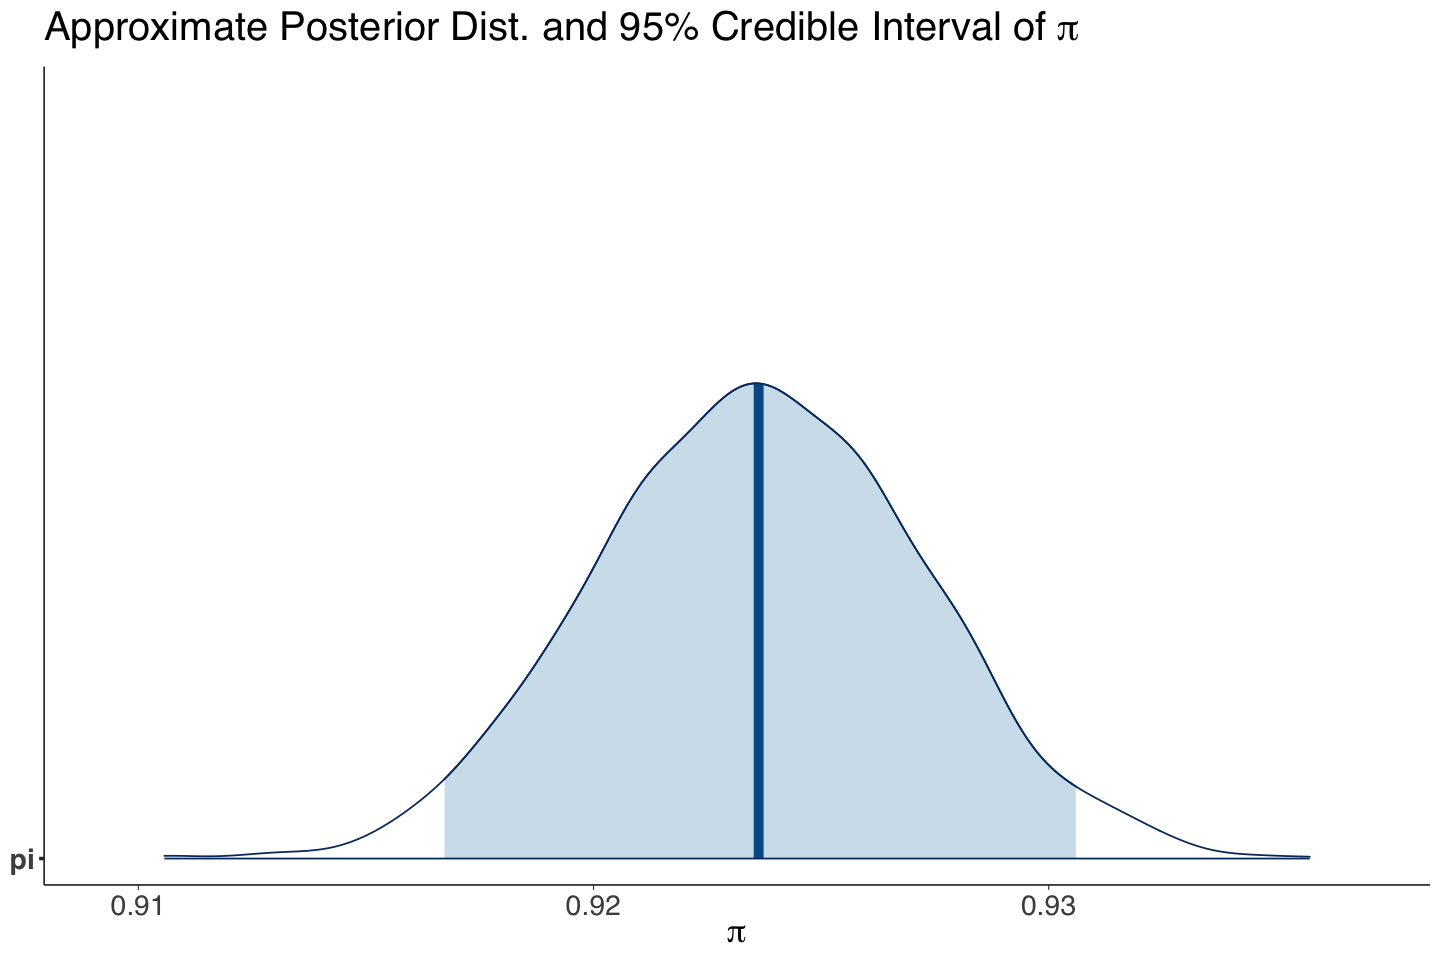

In [16]:
post_plot_Complete_Pooled_Rocket

```{exercise}
:label: lecture7-q2

Note that the approximate 95% credible interval for $\pi$ is $(0.917, 0.931)$. Is this interval an indicator of high precision on the estimation of $\pi$?

**A.** Yes.

**B.** No.
```

## 4. Let Us Go to Space!

You told a certain CEO from a rocket company that you wanted to go to space, and they asked you to pick your preferred rocket model from the `rockets` dataset. **Let us try to decide which rocket we trust the most.** Therefore, the Bayesian `Complete_Pooled_Rocket` is not suitable for this purpose **since it makes inference on a single $\pi$**!

We will start with a similar approach such as in `lab1` for the helicopter problem. 

Firstly, **we will only trust our observed data (i.e., the likelihood) without relying on the Bayes' rule**. This will implicate using **maximum likelihood estimation** to compute $\hat{\pi}_i$ for the $i$th rocket $(i = 1, \dots, 367)$. In a Binomial likelihood, we know the maximum likelihood estimate (MLE) is:

$$\hat{\pi}_i = \frac{x_i}{n_i},$$

where $x_i$ and $n_i$ are the respective **observed** numbers of successes and trials.

We will compute $\hat{\pi}_i$ in `rockets` **so we can select that rocket with the largest estimation for its launch success probability**. 

In [17]:
options(repr.matrix.max.rows = 60)

rockets <- rockets |>
  mutate(MLE = (numberOfLaunches - numberOfFailures) / numberOfLaunches)

rockets |>
  arrange(-MLE, LV.Type)

LV.Type,numberOfLaunches,numberOfFailures,MLE
<chr>,<dbl>,<dbl>,<dbl>
ARPA Taurus,2,0,1
Aerobee,1,0,1
Angara A5,1,0,1
Antares 110,2,0,1
Antares 120,2,0,1
Antares 230,1,0,1
Ariane 40,7,0,1
Ariane 42L,13,0,1
Ariane 44P,15,0,1


**We can see there is more than one rocket with a 100% success rate!** Nevertheless, **they often could have a small number of launches**. So we might not trust those rockets all that much. **MLE is frequentist-based; thus, it heavily relies on large sample sizes!**

Bayesian inference can help us decide while considering sample size by rocket with the upcoming model.

## 5.  Non-Pooled Rocket Model

Our third Bayesian approach is a **non-pooled model**. In this model, we will make inference on the 367 different success probabilities (one by rocket) in a single `Stan` model. This approach goes to the other extreme when compared to `Complete_Pooled_Rocket`!

For the $i$th rocket, the model is:

```{math}
\begin{align*}
\text{likelihood:} \qquad X_i|\pi_i \sim \text{Binomial}(n_i, \pi_i) \quad \text{for } i = 1, \dots, 367\\
\text{prior:} \qquad \pi_i \sim \text{Beta}(a = 1,b = 1).
\end{align*}
```

```{exercise}
:label: lecture7-q3

In this **non-pooled model**, is it possible to make inference on an overall $\pi$?

**A.** Yes.

**B.** No.
```

### 5.1. Coding the Model

We code up this `Non_Pooled_Rocket` model on `Stan`. The `data` block structure from `Complete_Pooled_Rocket` remains. However, **we tweak the `model` block to assign the same prior `beta(a,b)` by rocket probability**. Furthermore, **the `parameters` block is adapted to have a vector of probabilities `pi` of size `num_rockets`**.

In [18]:
Non_Pooled_Rocket <- "data {                          
int<lower=1> num_rockets;     // number of rockets 
int<lower=0> X[num_rockets];  // vector with sucesses by rocket
int<lower=1> n[num_rockets];  // vector with trials by rocket
real<lower=0> a;
real<lower=0> b;  
}
parameters {
vector<lower=0,upper=1>[num_rockets] pi;  // vector of 367 probabilities of success (one per rocket)
}
model {
for (i in 1:num_rockets){
pi[i] ~ beta(a,b);           // prior for pi_i by rocket
X[i] ~ binomial(n[i],pi[i]); // modelling the likelihood by rocket
}
}"

### 5.2. Running the MCMC Simulation

To run the `Non_Pooled_Rocket` model, we need to use the corresponding columns from `rockets`. The dictionary is identical to `Complete_Pooled_Rocket_dictionary`.

In [19]:
Non_Pooled_Rocket_dictionary <- list(
  num_rockets = nrow(rockets),
  X = rockets$numberOfLaunches - rockets$numberOfFailures,
  n = rockets$numberOfLaunches,
  a = 1, b = 1
)

In [20]:
posterior_Non_Pooled_Rocket <- stan(
  model_code = Non_Pooled_Rocket,
  data = Non_Pooled_Rocket_dictionary,
  chains = 1,
  iter = 10000,
  warmup = 1000,
  thin = 5,
  seed = 553,
)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 8.3e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.83 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 1001 / 10000 [ 10%]  (Sampling)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Sampling)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Sampling)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Sampling)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.194 seconds (Warm-up)
Chain 1:                7.645 seconds (Sampling)
Chain 1

### 5.3. Output Summary 

We obtain the output from `Non_Pooled_Rocket`. Since `Stan` labels the parameters in the posterior samples as `pi[1]`, ..., `pi[367]`, we will add a new column with the actual `rocket` name using `rockets$LV.Type`.

In [21]:
options(repr.matrix.max.rows = 15)

summary_Non_Pooled_Rocket <- as.data.frame(summary(posterior_Non_Pooled_Rocket)$summary)
summary_Non_Pooled_Rocket <- summary_Non_Pooled_Rocket[-368, c("mean", "sd", "2.5%", "97.5%")] |>
  mutate_if(is.numeric, round, 3)
summary_Non_Pooled_Rocket$rocket <- rockets$LV.Type
summary_Non_Pooled_Rocket |>
  arrange(-mean)

,mean,sd,2.5%,97.5%,rocket
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
pi[266],0.987,0.013,0.953,1.000,Soyuz-U2
pi[267],0.985,0.011,0.959,0.998,Space Shuttle
pi[261],0.984,0.016,0.941,0.999,Soyuz-FG
pi[357],0.978,0.015,0.942,0.997,Vostok 8A92M
pi[343],0.972,0.016,0.934,0.994,Tsiklon-2
pi[78],0.971,0.029,0.894,1.000,Chang Zheng 2D
pi[264],0.970,0.007,0.955,0.982,Soyuz-U
pi[16],0.969,0.021,0.916,0.996,Ariane 5ECA
⋮,⋮,⋮,⋮,⋮,⋮


Note that the top 3 rockets in the posterior values for $\pi_i$ do not correspond to the previous top 3 rockets in MLE from `rockets`. We can also plot the **top 10 rockets by posterior mean probability of launch** and the 95% credible intervals. Note the overlap across these ten rockets.

In [22]:
posterior_rocket_CIs_plot_Non_Pooled <- summary_Non_Pooled_Rocket |>
  arrange(-mean) |>
  slice(1:10) |>
  mutate(rocket = fct_reorder(rocket, mean)) |>
  ggplot(aes(x = mean, y = rocket)) +
  geom_errorbarh(aes(xmax = `2.5%`, xmin = `97.5%`, color = rocket)) +
  geom_point(color = "blue") +
  theme(
    plot.title = element_text(size = 24),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    legend.position = "none"
  ) +
  ggtitle(expression(paste("95% Credible Intervals for ", pi[i], " by Rocket (Non-Pooled)"))) +
  labs(x = "Probability of Launch Success", y = "Rocket") +
  scale_x_continuous(limits=c(0.85, 1), breaks = seq(0.85, , 0.025))

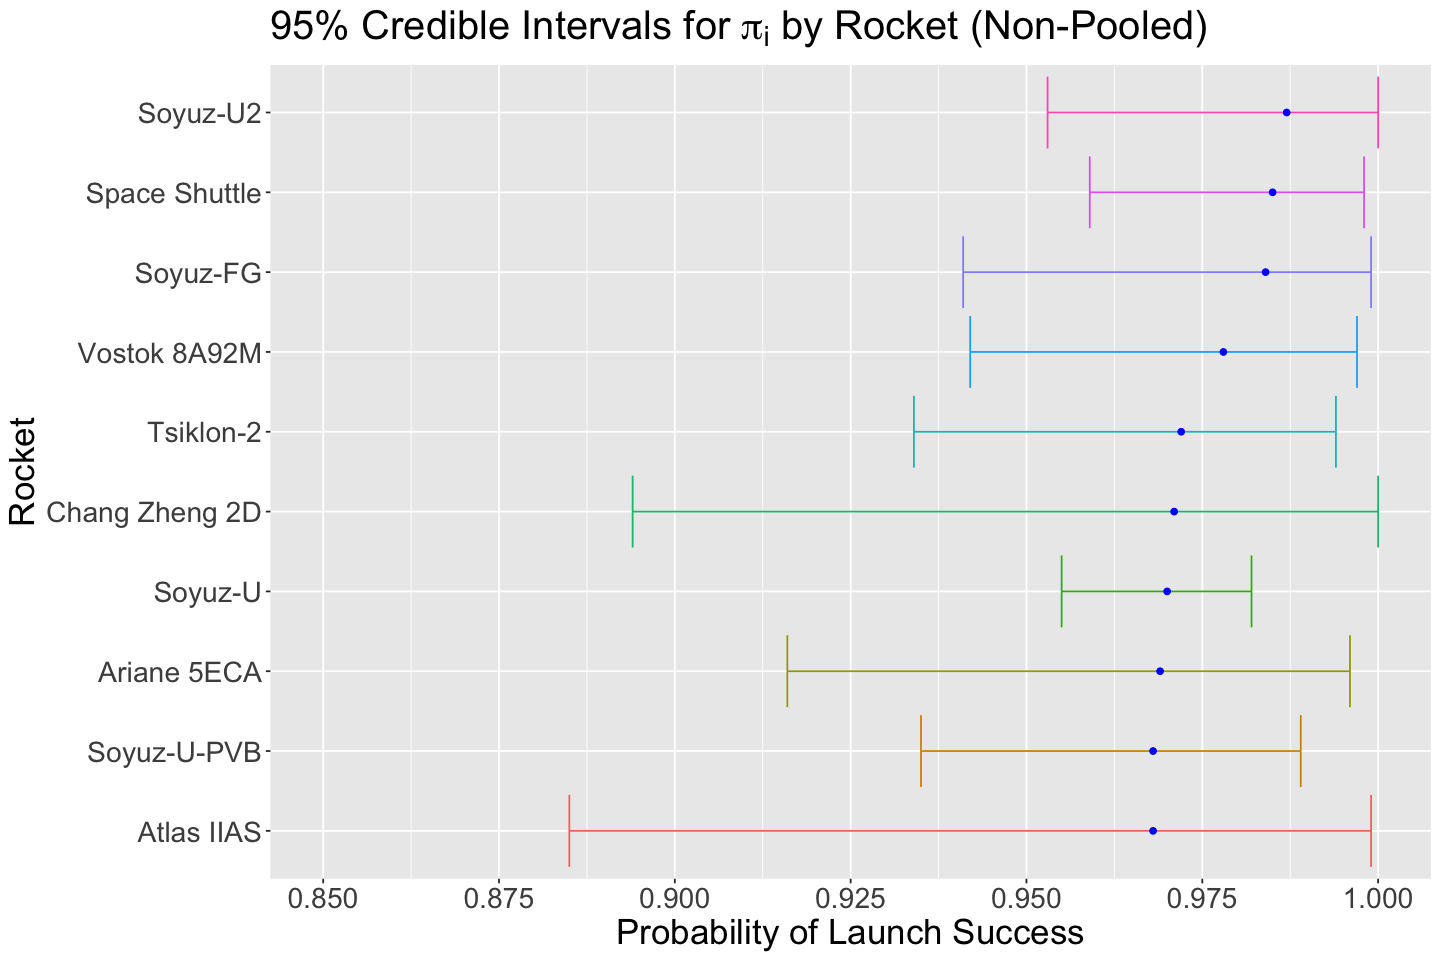

In [23]:
posterior_rocket_CIs_plot_Non_Pooled

Let us add our Bayesian posterior means to `rockets` and sort them from the largest posterior mean to the lowest.

In [24]:
options(repr.matrix.max.rows = 20)
rockets$posterior_non_pooled_means <- summary_Non_Pooled_Rocket$mean
rockets |>
  arrange(-posterior_non_pooled_means)

LV.Type,numberOfLaunches,numberOfFailures,MLE,posterior_non_pooled_means
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Soyuz-U2,72,0,1.0000000,0.987
Space Shuttle,135,1,0.9925926,0.985
Soyuz-FG,59,0,1.0000000,0.984
Vostok 8A92M,93,1,0.9892473,0.978
Tsiklon-2,105,2,0.9809524,0.972
Chang Zheng 2D,32,0,1.0000000,0.971
Soyuz-U,633,18,0.9715640,0.970
Ariane 5ECA,61,1,0.9836066,0.969
Atlas IIAS,30,0,1.0000000,0.968


```{exercise}
:label: lecture7-q4

From `rockets`, which one of the two estimators (MLE or the posterior mean with `Non_Pooled_Rocket`) do you think is more helpful in choosing your rocket?
```

## 6. Hierarchical Rocket Model

Except for the initial warmup model (which is a single iteration of `Non_Pooled_Rocket`!), we have tried different Bayesian models using two opposite approaches:

- `Complete_Pooled_Rocket`: We obtained approximate posterior samples for $\pi$, the overall probability of launch success. **However, this approach does not allow us to infer any probability of an individual rocket.**
- `Non_Pooled_Rocket`: We obtained approximate posterior samples for the probability of launch success $\pi_i$ by **EACH** rocket type.

To choose the most successful rocket, `Non_Pooled_Rocket` worked reasonably better than MLE. However, recall the formal modelling:

```{math}
\begin{align*}
\text{likelihood:} \qquad X_i|\pi_i \sim \text{Binomial}(n_i, \pi_i) \quad \text{for } i = 1, \dots, 367\\
\text{prior:} \qquad \pi_i \sim \text{Beta}(a = 1, b = 1).
\end{align*}
```

```{caution}
**Why should we restrict our prior for each $\pi_i$ to fixed hyperparameters $a$ and $b$ for the Beta distribution?** We have only been using $\text{Beta}(a = 1, b = 1)$ thorughout the whole lecture!
```

There are other important drawbacks in `Non_Pooled_Rocket`:

- Firstly, **we cannot generalize this model to some new rocket**. 
- Secondly, **we would not take any valuable information provided by some rocket type to infer on another type in `rockets`**.

**Here comes another Bayesian twist!** To make the model even more flexible, let us make $a$ and $b$ random too in the Beta prior. Hence, $a$ and $b$ will become parameters too (**and not hyperparameters!**).

```{important}
This is the foundational point of a **hierarchical model**. This hierarchical model will take into account two sources of variability (different to the predictive sources of variability we saw in {doc}`lecture5_hypothesis_testing_intro_regression`):

- **Within-group variability:** How much variability we have among the observations within each group of interest. In this case, the group is a rocket type, while the observations are different trials.
- **Between-group variability:** How much variability we have from group to group. In this example, we can assess this matter from one rocket type to another.

Essentially, the hierarchical model takes the best of `Non_Pooled_Rocket` and `Complete_Pooled_Rocket`. **Note it will be able to infer on the following:**

- It will use valuable information from all the `rockets` in the dataset to infer the launch success probability on **a specific rocket**.
- We can obtain the posterior predictive distribution of the launch success probability **for a new rocket**.
```

Our hierarchical model is formally defined as:

```{math}
\begin{align*}
\text{likelihood:} \qquad X_i|\pi_i \sim \text{Binomial}(n_i, \pi_i) \quad \text{for } i = 1, \dots, 367\\
\text{priors:} \qquad \pi_i \sim \text{Beta}(a, b) \\
\quad a \sim \text{Gamma}(0.001, 0.001) \\
\qquad b \sim \text{Gamma}(0.001, 0.001).
\end{align*}
```

```{admonition} What is the big picture here?
:class: hint
First, **this hierarchical model learns a different $\pi_i$ from each rocket type**. The key here is that the data from all rockets contribute to our inferences about $a$ and $b$. Thus, **it is like our prior for each rocket is being set by all the rockets!**
```

### 6.1. The Priors

**Why a Gamma distribution for $a$ and $b$?**

Recall the probability density function (PDF) of the Beta distribution:

$$f(\pi_i) = \frac{\Gamma(a + b)}{\Gamma(a) \Gamma(b)} \pi_i ^{a - 1} (1 - \pi_i)^{b - 1} \quad \text{for} \quad 0 \leq \pi_i \leq 1.$$

In this PDF, we have that $a > 0$ and $b > 0$ are continuous. Thus, **a nonnegative continuous Gamma is suitable in this case**.

In [25]:
# Plotting Gamma prior
prior_gamma <- ggplot() +
  xlim(0, 10) +
  ylim(0, 10) +
  geom_function(fun = dgamma, args = list(shape = 0.001, rate = 0.001), linewidth = 2) +
  geom_vline(xintercept = 0.00001, colour = "darkred", linetype = "dashed", linewidth = 2) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21),
  ) +
  labs(y = "Density", x = "Hierarchical Parameter") +
  ggtitle("Prior Gamma(0.001, 0.001) for a and b" )

The corresponding Gamma prior distribution for $a$ and $b$ are plotted below (the prior mean is the vertical dashed red line).

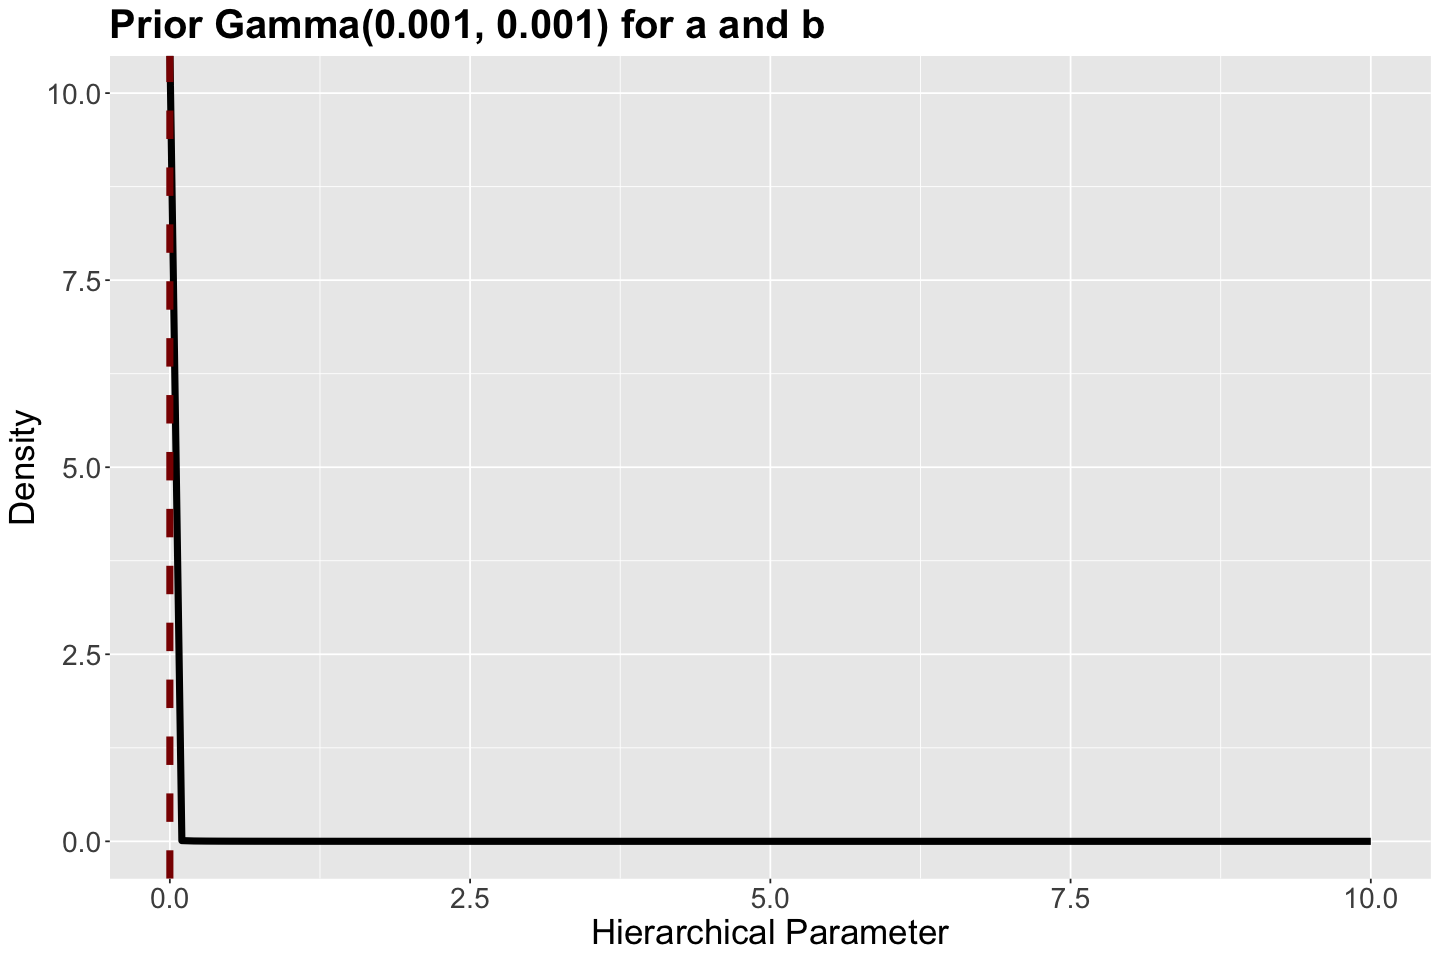

In [26]:
prior_gamma

Note the Gamma priors **tend to assign small values** for $a$ and $b$ in
    
$$\pi_i \sim \text{Beta}(a, b).$$

**As an example**, for a given $\pi_i$, suppose its Beta prior has $a = 0.0002$ and $b = 0.0005$. This Beta prior for $\pi_i$ is plotted below. We can see these prior beliefs for $a$ and $b$ basically put the success probability $\pi_i$ close to either its lower or upper bound. Translating this into our prior beliefs, **we think that any rocket would be either good or bad (we do not want any intermediate point here since we are using that rocket to go to space!).**

In [27]:
# Plotting Beta prior
prior_beta <- ggplot() +
  xlim(0, 1) +
  geom_function(fun = dbeta, args = list(shape1 = 0.0002, shape2 = 0.0005), linewidth = 2) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21),
  ) +
  labs(y = "Density", x = expression(pi["i"])) +
  ggtitle("Example of a Possible Prior Beta(0.0002, 0.0005)")

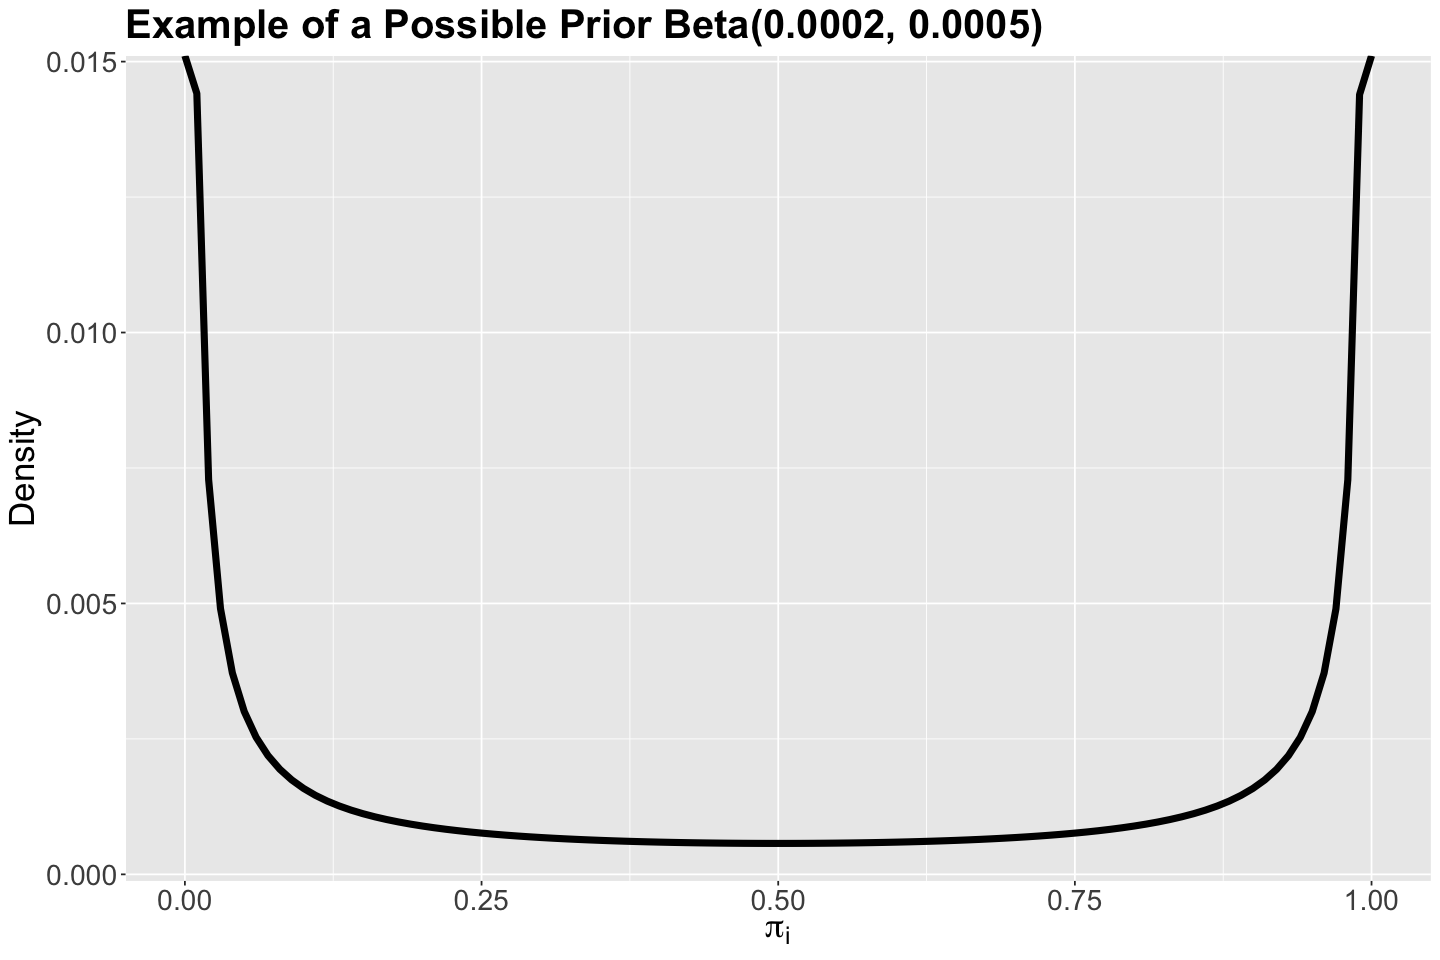

In [28]:
prior_beta

### 6.2. Coding the Model

We code up this `Hierarchical_Rocket` model on `Stan`: 

- The `data` block structure will not have `a` and `b` since they are random now. 
- Furthermore, we add the Gamma priors for $a$ and $b$ in the `model` block while keeping the Beta prior for each $\pi_i$. 
- The `parameters` block has new variables: `a` and `b`. 
- Besides the posterior sampled probabilities by rocket type, we will also obtain posterior samples for  $a$ and $b$.

In [29]:
Hierarchical_Rocket <- "data {                          
int<lower=1> num_rockets;    // number of rockets 
int<lower=0> X[num_rockets];  // vector with sucesses by rocket
int<lower=1> n[num_rockets];  // vector with trials by rocket
}
parameters {
vector<lower=0,upper=1>[num_rockets] pi; // vector of 367 probabilities of launch success
real<lower=0> a; // beta parameter
real<lower=0> b; // beta parameter
}
model {
a ~ gamma(0.001, 0.001);     // prior for a
b ~ gamma(0.001, 0.001);     // prior for b

for (i in 1:num_rockets){
pi[i] ~ beta(a,b);           // modelling the pi_i by rocket
X[i] ~ binomial(n[i],pi[i]); // modelling the likelihood by rocket
}
}"

### 6.3. Running the MCMC Simulation

To run the `Hierarchical_Rocket` model, we need to use the corresponding columns from `rockets`. This dictionary will not have `a` and `b`.

In [30]:
Hierarchical_Rocket_dictionary <- list(
  num_rockets = nrow(rockets),
  X = rockets$numberOfLaunches - rockets$numberOfFailures,
  n = rockets$numberOfLaunches
)

In [31]:
posterior_Hierarchical_Rocket <- stan(
  model_code = Hierarchical_Rocket,
  data = Hierarchical_Rocket_dictionary,
  chains = 1,
  iter = 10000,
  warmup = 1000,
  thin = 5,
  seed = 553,
)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 7e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 1001 / 10000 [ 10%]  (Sampling)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Sampling)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Sampling)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Sampling)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.944 seconds (Warm-up)
Chain 1:                12.514 seconds (Sampling)
Chain 1: 

### 6.4. Output Summary 

We obtain the output from `posterior_Hierarchical_Rocket`. Since `Stan` labels the parameters in the posterior samples as `pi[1]`, ..., `pi[367]`, we will add a new column with the actual `rocket` name using `rockets$LV.Type`.

In [32]:
options(repr.matrix.max.rows = 12)
summary_Hierarchical_Rocket <- as.data.frame(summary(posterior_Hierarchical_Rocket)$summary)
summary_Hierarchical_Rocket <- summary_Hierarchical_Rocket[1:367, c("mean", "sd", "2.5%", "97.5%")] |>
  mutate_if(is.numeric, round, 3)
summary_Hierarchical_Rocket$rocket <- rockets$LV.Type
summary_Hierarchical_Rocket |>
  arrange(-mean)

,mean,sd,2.5%,97.5%,rocket
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
pi[266],0.991,0.011,0.961,1.000,Soyuz-U2
pi[261],0.989,0.013,0.956,1.000,Soyuz-FG
pi[267],0.988,0.010,0.963,0.999,Space Shuttle
pi[357],0.983,0.013,0.950,0.998,Vostok 8A92M
pi[78],0.982,0.021,0.923,1.000,Chang Zheng 2D
pi[54],0.980,0.023,0.915,1.000,Atlas IIAS
⋮,⋮,⋮,⋮,⋮,⋮
pi[192],0.545,0.074,0.398,0.685,Molniya 8K78
pi[184],0.544,0.155,0.241,0.821,Lambda 4S


We plot the top 10 rockets and the posterior 95% credible intervals from `posterior_Hierarchical_Rocket`. Then we compare this top 10 versus the ones obtained with `posterior_Non_Pooled_Rocket`. The credible interval overlapping is still there. 

Nonetheles, for those rockets still present in the top 10 from `posterior_Hierarchical_Rocket`, the credible intervals are narrower! **We have more precise results.**

In [33]:
posterior_rocket_CIs_plot_Hierarchical <- summary_Hierarchical_Rocket |>
  arrange(-mean) |>
  slice(1:10) |>
  mutate(rocket = fct_reorder(rocket, mean)) |>
  ggplot(aes(x = mean, y = rocket)) +
  geom_errorbarh(aes(xmax = `2.5%`, xmin = `97.5%`, color = rocket)) +
  geom_point(color = "blue") +
  theme(
    plot.title = element_text(size = 24),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    legend.position = "none"
  ) +
  ggtitle(expression(paste("95% Credible Intervals for ", pi[i], " by Rocket (Hierarchical)"))) +
  labs(x = "Probability of Launch Success", y = "Rocket") +
  scale_x_continuous(limits = c(0.85, 1), breaks = seq(0.85, , 0.025))

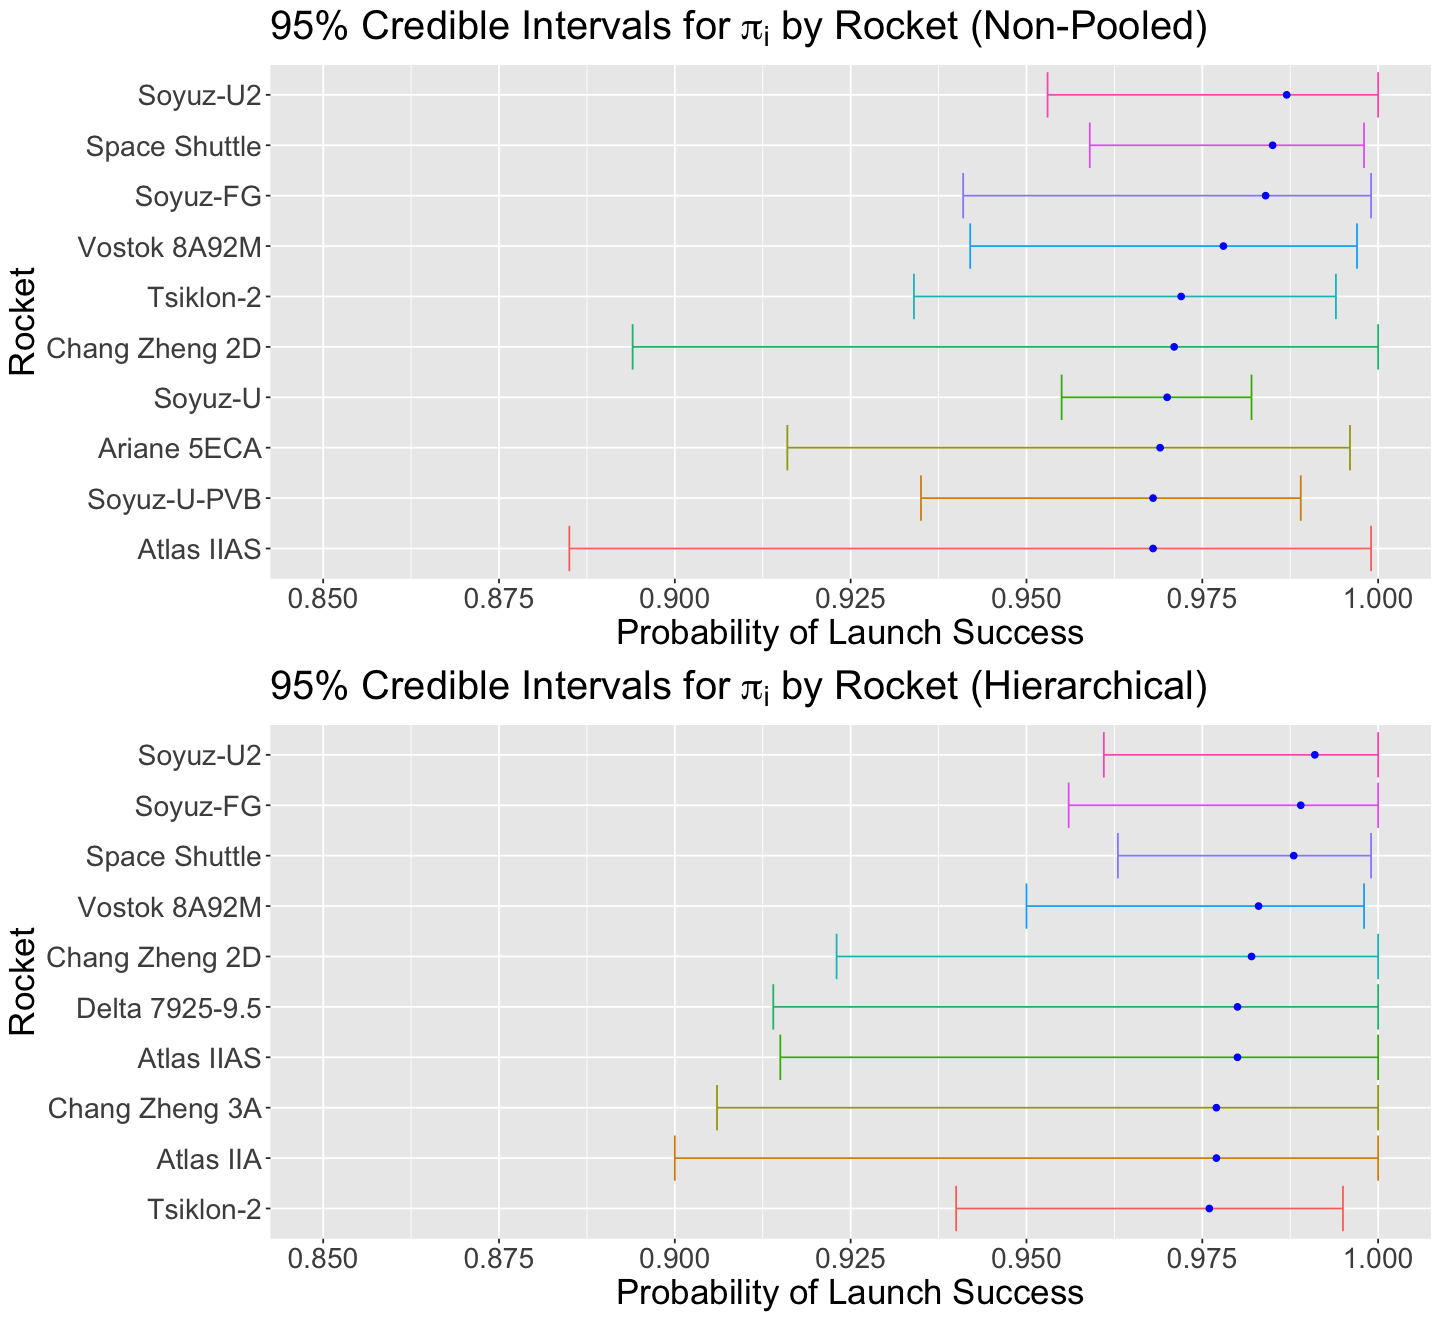

In [34]:
options(repr.plot.height = 11, repr.plot.width = 12)

plot_grid(posterior_rocket_CIs_plot_Non_Pooled, posterior_rocket_CIs_plot_Hierarchical, nrow = 2)

```{admonition} So, what rocket should we choose with a hierarchical model?
:class: hint
If we had to choose based on the **hierarchical** Bayesian results, we would still take `Soyuz-U2` or `Space Shuttle` (now with narrower 95% credible intervals!).
```

**Why are our estimates more precise?**

A useful property of hierarchical models is the notion of **"borrowing strength"**, where a rocket uses the information about the probability of success from other rockets. As we saw above, this affects the mean of our posterior distributions, but it also affects the variance. **This helps us to learn the parameters and actually reduce the posterior variance of our Bayesian estimates!**

**How about the posterior results for $a$ and $b$?**

Also, we have posterior summaries for `a` and `b`.

In [35]:
summary_Hierarchical_Rocket_ab <- as.data.frame(summary(posterior_Hierarchical_Rocket)$summary)
summary_Hierarchical_Rocket_ab <- summary_Hierarchical_Rocket_ab[368:369, c("mean", "sd", "2.5%", "97.5%")] |>
  mutate_if(is.numeric, round, 3)
summary_Hierarchical_Rocket_ab

,mean,sd,2.5%,97.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,4.673,0.933,3.133,6.616
b,0.685,0.109,0.490,0.911


Note the posterior distributions of $a$ and $b$ are right-skewed.

In [36]:
post_plot_Hierarchical_Rocket_ab <- mcmc_areas(posterior_Hierarchical_Rocket, pars = c("a", "b"), prob = 0.95) +
  theme(
    plot.title = element_text(size = 24, face = "bold", family = "sans"),
    axis.text.x = element_text(size = 17, angle = 0, family = "sans"),
    axis.text.y = element_text(size = 17, angle = 0, family = "sans"),
    axis.title = element_text(size = 21, family = "sans"),
    strip.text.x = element_text(size = 17, family = "sans")
  ) +
  ggtitle("Approximate Posterior Distributions of a and b")

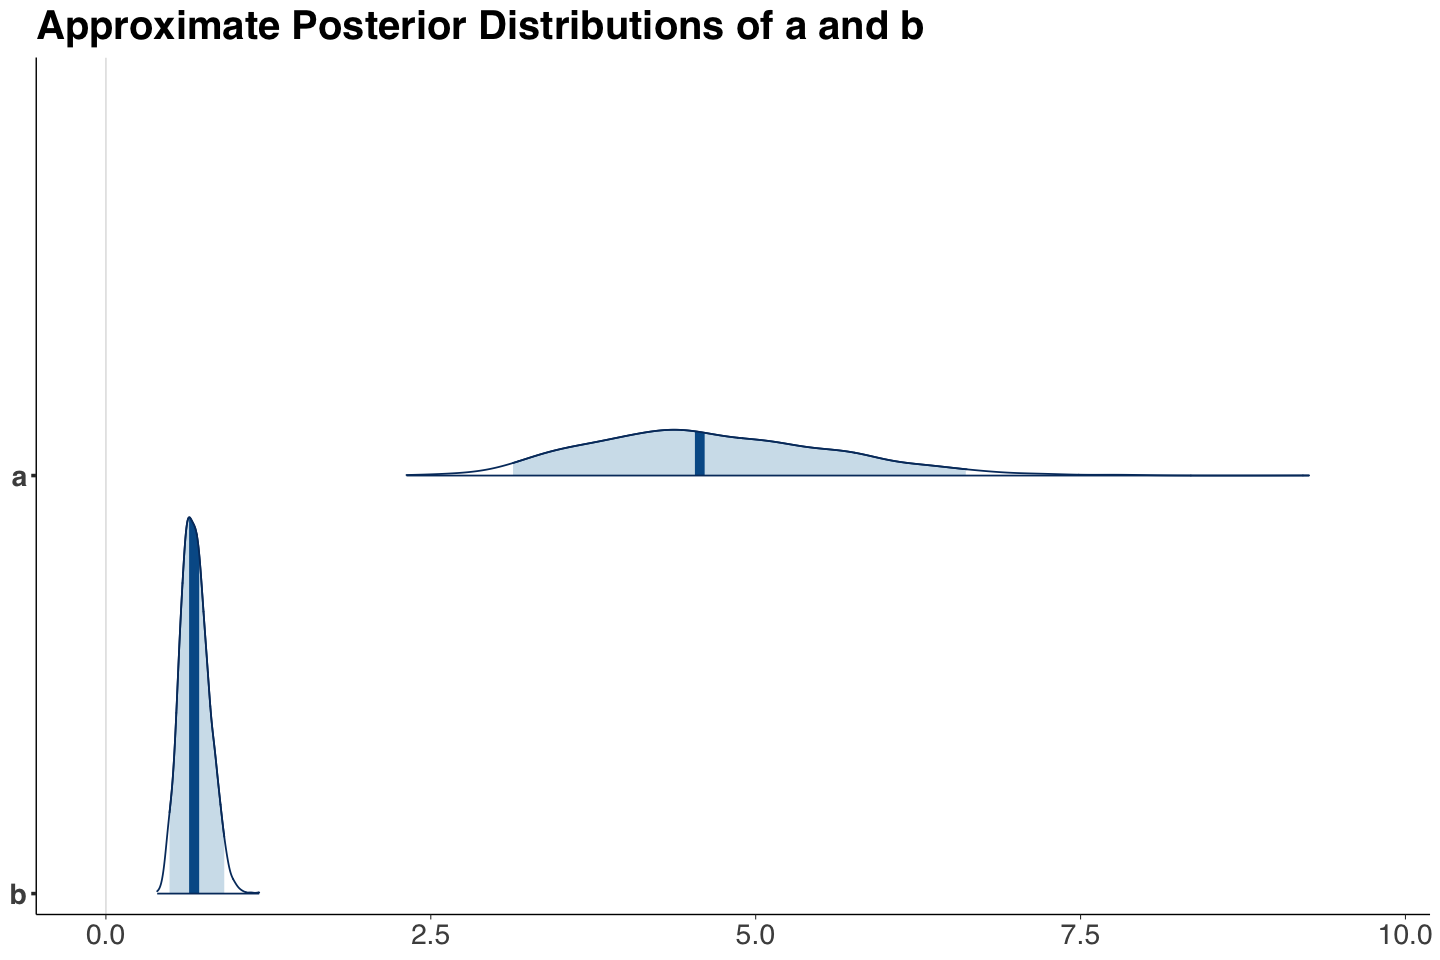

In [37]:
options(repr.plot.height = 8, repr.plot.width = 12)

post_plot_Hierarchical_Rocket_ab

**How is the average launch success probability for all the `rockets`?**

We will use the posterior means of $a$ and $b$ as parameters of a Beta distribution to report posterior metrics on the **average launch probability of success $\pi$**

In [38]:
summary_Hierarchical_Rocket_ab

,mean,sd,2.5%,97.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,4.673,0.933,3.133,6.616
b,0.685,0.109,0.490,0.911


Using the posterior means for `a` and `b` from `summary_Hierarchical_Rocket_ab`, let us deliver the summary statistics for a theoretical Beta distribution via `summarize_beta()` from package `bayesrules`.

In [39]:
summarize_beta(alpha = summary_Hierarchical_Rocket_ab$mean[1], beta = summary_Hierarchical_Rocket_ab$mean[2]) |>
  mutate_if(is.numeric, round, 3)

mean,mode,var,sd
<dbl>,<dbl>,<dbl>,<dbl>
0.872,1,0.018,0.132


Then, using posterior means $a = 4.673$ and $b = 0.685$, we plot this **average posterior theoretical Beta**. Note that its corresponding mean $0.872$ is indicated as a vertical dashed line.

In [40]:
# Plotting average Beta posterior
average_beta_posterior <- ggplot() +
  xlim(0, 1) +
  ylim(0, 10) +
  geom_function(fun = dbeta, args = list(shape1 = 4.673, shape2 = 0.685), linewidth = 2) +
  geom_vline(xintercept = 0.872, colour = "darkred", linetype = "dashed", linewidth = 2) +
  theme(
    plot.title = element_text(size = 24),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21),
  ) +
  labs(y = "Density", x = expression(pi)) +
  ggtitle(expression(paste("Average Posterior Beta(4.771, 0.699) for ", pi)))

This average Beta posterior leans more towards high probabilities for launch success **given the evidence provided by all `rockets` along with our priors**.

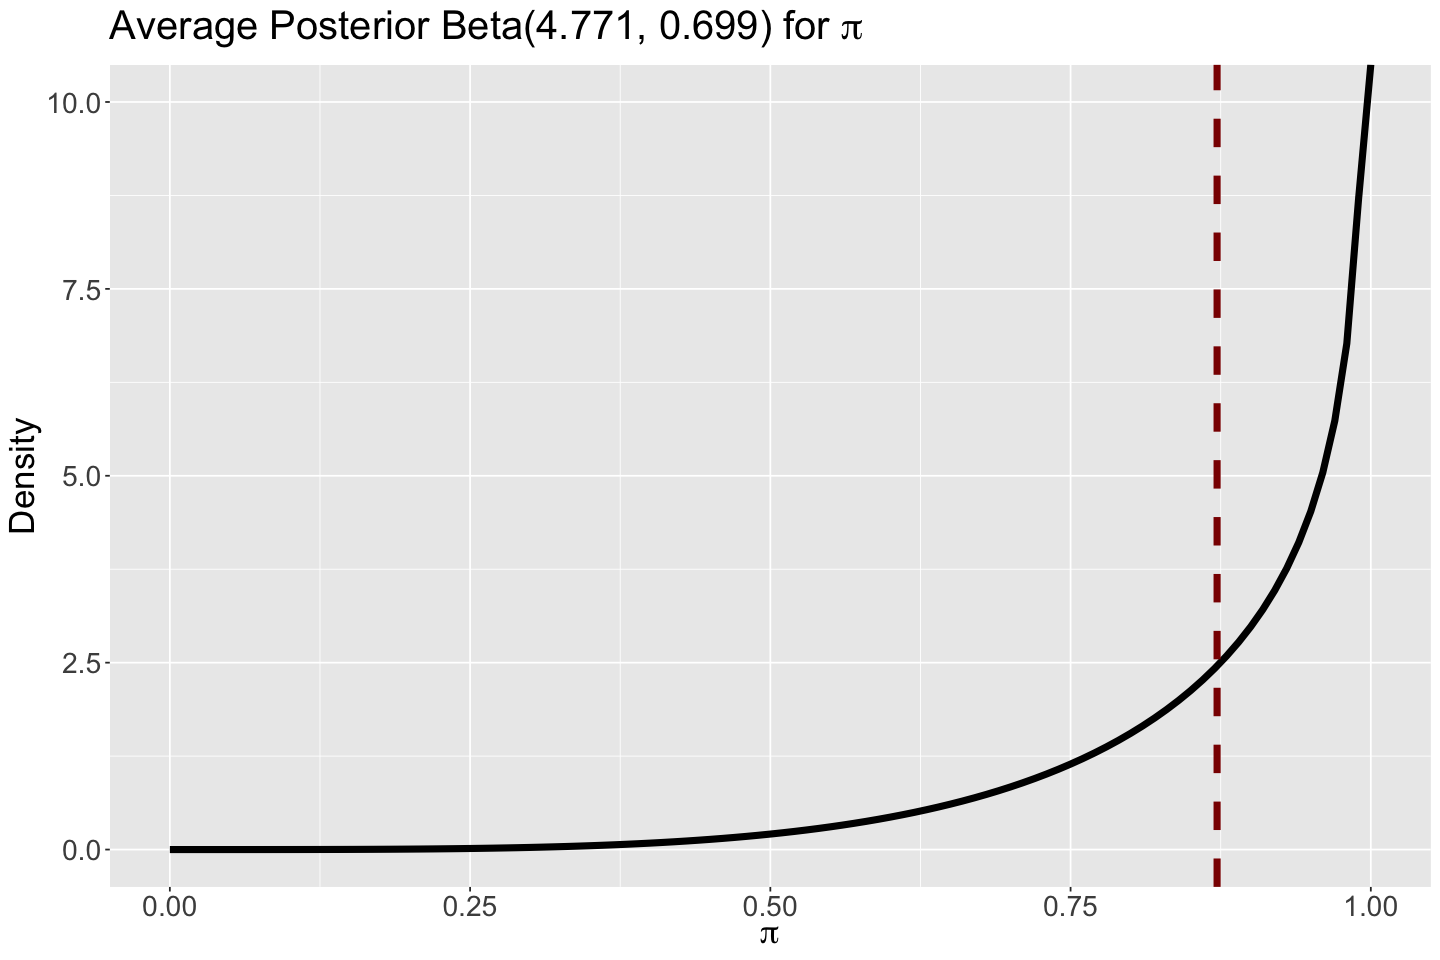

In [41]:
options(repr.plot.height = 8, repr.plot.width = 12)

average_beta_posterior

### 6.5. Prediction for a New Rocket

We will modify our `Hierarchical_Rocket` model to incorporate the block `generated quantities` for a predicted probability `pi_pred`. We use the same process described in {doc}`lecture5_hypothesis_testing_intro_regression` to obtain predictions. This process considers the **posterior variability in `parameters`** and the **sampling variability**. The predictive samples will yield a **posterior predictive distribution** for `pi_pred`.

In [42]:
pred_Hierarchical_Rocket <- "data {                          
int<lower=1> num_rockets;    // number of rockets 
int<lower=0> X[num_rockets];  // vector with sucesses by rocket
int<lower=1> n[num_rockets];  // vector with trials by rocket
}
parameters {
vector<lower=0,upper=1>[num_rockets] pi; // vector of 367 probabilities of launch success
real<lower=0> a; // beta parameter
real<lower=0> b; // beta parameter
}
model {
a ~ gamma(0.001, 0.001);     // prior for a
b ~ gamma(0.001, 0.001);     // prior for b

for (i in 1:num_rockets){
pi[i] ~ beta(a,b);           // modelling the pi_i by rocket
X[i] ~ binomial(n[i],pi[i]); // modelling the likelihood by rocket
}
}
generated quantities {
  real<lower=0,upper=1> pi_pred = beta_rng(a, b);
}"

The MCMC simulation uses the same `Hierarchical_Rocket_dictionary` but the modified `pred_Hierarchical_Rocket`.

In [43]:
pred_posterior_Hierarchical_Rocket <- stan(
  model_code = pred_Hierarchical_Rocket,
  data = Hierarchical_Rocket_dictionary,
  chains = 1,
  iter = 10000,
  warmup = 1000,
  thin = 5,
  seed = 553,
)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 8.4e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.84 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 1001 / 10000 [ 10%]  (Sampling)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Sampling)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Sampling)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Sampling)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.792 seconds (Warm-up)
Chain 1:                12.019 seconds (Sampling)
Chain 

We only need the posterior metrics for `pi_pred`. **Note the mean is extremely similar to the overall mean of $\pi$!** Moreover, the posterior predictive distribution in `post_hist_Hierarchical_Rocket_pi_pred` is similar to `average_beta_posterior`. 

In [44]:
summary_Hierarchical_Rocket_pi_pred <- as.data.frame(summary(pred_posterior_Hierarchical_Rocket)$summary)
summary_Hierarchical_Rocket_pi_pred <- summary_Hierarchical_Rocket_pi_pred[370, c("mean", "sd", "2.5%", "97.5%")] |>
  mutate_if(is.numeric, round, 3)
summary_Hierarchical_Rocket_pi_pred

,mean,sd,2.5%,97.5%
,<dbl>,<dbl>,<dbl>,<dbl>
pi_pred,0.876,0.135,0.511,0.999


In [45]:
post_hist_Hierarchical_Rocket_pi_pred <- mcmc_areas(pred_posterior_Hierarchical_Rocket, pars = c("pi_pred"), prob = 0.95) +
  theme(
    plot.title = element_text(size = 24, family = "sans"),
    axis.text.x = element_text(size = 17, angle = 0, family = "sans"),
    axis.text.y = element_text(size = 17, angle = 0, family = "sans"),
    axis.title = element_text(size = 21, family = "sans"),
    strip.text.x = element_text(size = 21, family = "sans")
  ) +
  ggtitle(expression(paste("Approximate Posterior Distribution of Predicted ", pi))) +
  xlab(expression(paste("Predicted ", pi)))

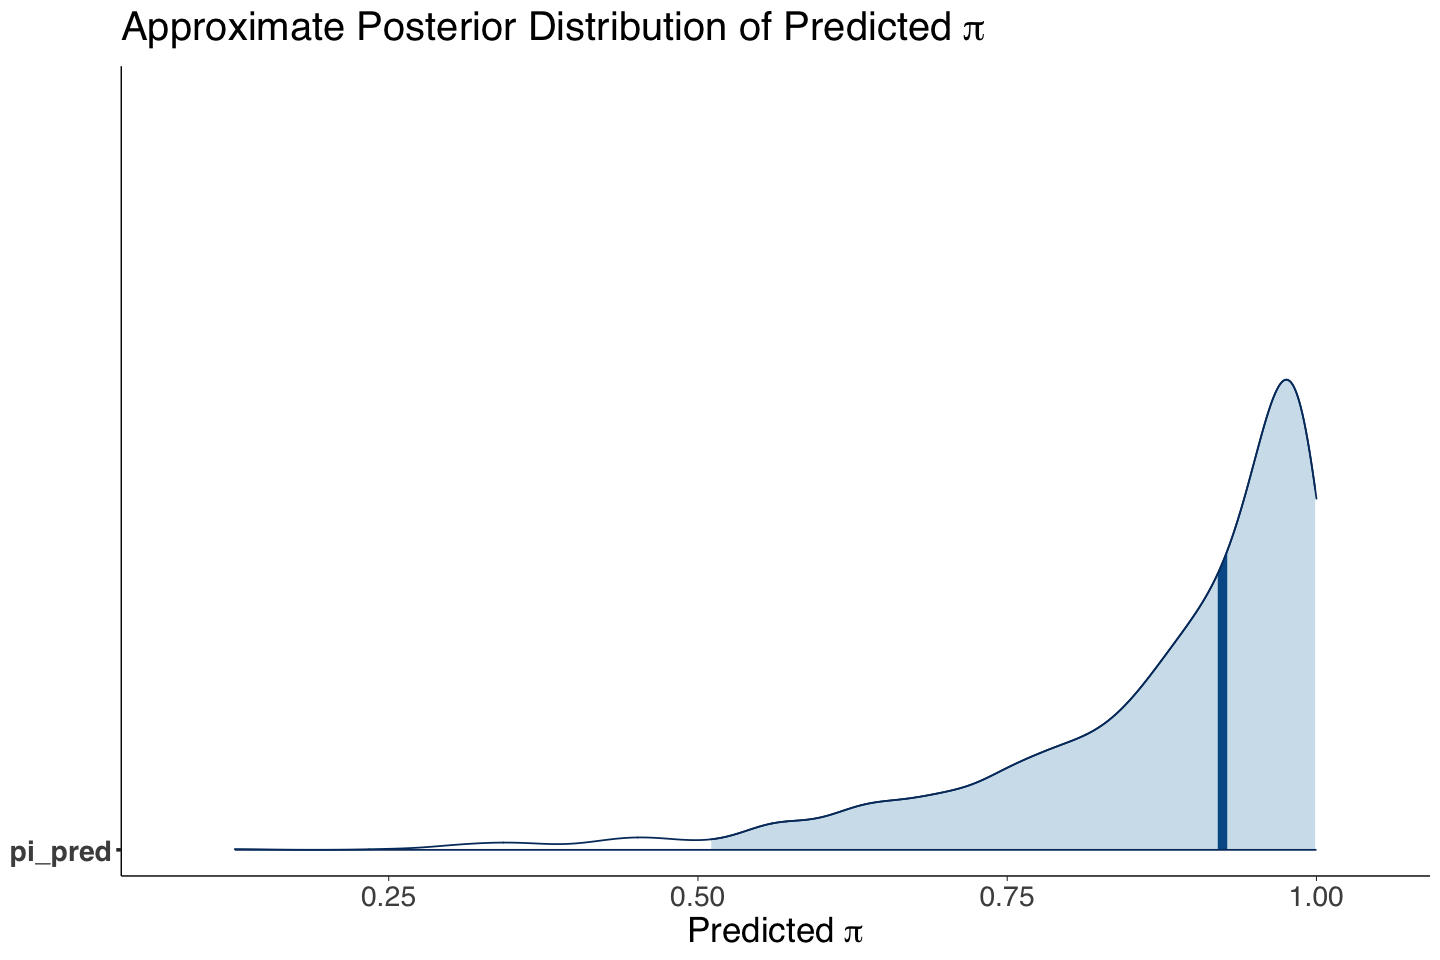

In [46]:
post_hist_Hierarchical_Rocket_pi_pred

```{admonition} Why do we have these similarities?
:class: warning
Our launch success mean posterior prediction for a new rocket is similar to the posterior mean of $\pi$ because **this is the best Bayesian model we can obtain without further covariates (or features)**! So, this is a mean probability prediction for the rocket population for a launch success.
```

## 7. Wrapping Up

- Even though hierarchical models involve more Bayesian complexity, they are helpful to take the best from non-pooled and pooled models.
- These hierarchical models are also flexible enough to provide predictions for new observations.
- We saw a model without covariates. Nevertheless, the hierarchical approach can be extended to Bayesian regression models. These are the counterpart of frequentist mixed-effects models.